In [28]:
!pip install aesthetix

In [56]:
import aesthetix as at
import numpy as np 

In [30]:
import os
if "tweets.csv" not in os.popen("ls").read():
  !wget https://raw.githubusercontent.com/Stellarator-X/ConvoBot/servus/Programming%20Assignments/Response%20Generation/LDA/tweets.csv

In [133]:
import pandas as pd
df_tweets = pd.read_csv('tweets.csv')
df_tweets.head(2)

,text,created_at
0,Hogan Gidley will be leaving the White House o...,06-23-2020 17:23:40
1,....Dr. Anthony Fauci who is with us in all wa...,06-23-2020 14:41:52


In [32]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [33]:
from nltk.corpus import stopwords
en_stop_words = set(stopwords.words('english'))
list(en_stop_words)[:10]

['each', 'whom', 'had', 'more', 'that', 'same', 'no', 'an', 'to', 'wasn']

In [134]:
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from datetime import datetime
import pandas as pd
import re
import math

def clean_tweets(df=df_tweets, 
                 tweet_col='text', 
                 date_col='created_at',
                 start_datetime=datetime(2017,1,20, 0, 0, 0)
                ):
    
    df_copy = df.copy()
    
    # drop rows with empty values
    df_copy.dropna(inplace=True)
    
    # format the date
    df_copy[date_col] = df_copy[date_col].apply(lambda row: datetime.strptime(row, '%m-%d-%Y %H:%M:%S'))
    
    # filter rows older than a given date
    df_copy = df_copy[df_copy[date_col] >=start_datetime]
    
    # lower the tweets
    df_copy['preprocessed_' + tweet_col] = df_copy[tweet_col].str.lower()
    
    # filter out stop words and URLs
    en_stop_words = set(stopwords.words('english'))
    extended_stop_words = en_stop_words | \
                        {
                            '&amp;', 'rt',                           
                            'th','co', 're', 've', 'kim', 'daca'
                        }
    url_re = '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'        
    df_copy['preprocessed_' + tweet_col] = df_copy['preprocessed_' + tweet_col].apply(lambda row: ' '.join([word for word in row.split() if (not word in en_stop_words) and (not re.match(url_re, word))]))
    
    # tokenize the tweets
    tokenizer = RegexpTokenizer('[a-zA-Z]\w+\'?\w*')
    df_copy['tokenized_' + tweet_col] = df_copy['preprocessed_' + tweet_col].apply(lambda row: tokenizer.tokenize(row))
    
    return df_copy
  
df_tweets = pd.read_csv('tweets.csv')
df_tweets_clean = clean_tweets(df_tweets)
df_tweets_clean.head(2)

,text,created_at,preprocessed_text,tokenized_text
0,Hogan Gidley will be leaving the White House o...,2020-06-23 17:23:40,hogan gidley leaving white house july 1 headin...,"[hogan, gidley, leaving, white, house, july, h..."
1,....Dr. Anthony Fauci who is with us in all wa...,2020-06-23 14:41:52,....dr. anthony fauci us ways high 72% approva...,"[dr, anthony, fauci, us, ways, high, approval,..."


In [41]:
print(tweets_dictionary[1])

election


In [42]:
# Trying to build the same with tf tokenized sequences : our output :)
from tensorflow.keras.preprocessing.text import Tokenizer, tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences

oov_token = "<OOV>"
tokenizer = Tokenizer(oov_token=oov_token)
tokenizer.fit_on_texts(df_tweets_clean.preprocessed_text)

In [43]:
word_index= tokenizer.word_index
index_word = {word_index[word]:word for word in word_index}

print(index_word[2])

rt


In [44]:
seq = tokenizer.texts_to_sequences(df_tweets_clean.preprocessed_text)

In [45]:
def build_lda_corpus(sequences, verbose = False):
  corpus = []
  net = len(sequences)
  for num, line in enumerate(sequences):
    if verbose : at.progress_bar("Generating the Corpus  : ", num, net)
    counts = [line.count(elt) for elt in line]
    line_ = list(set([(line[i], counts[i]) for i in range(len(counts))]))
    corpus.append(line_)
  return corpus


In [46]:
corpus  = build_lda_corpus(seq, True)

Generating the Corpus  : :[==============================](100.00%)  


In [47]:
new_lda = LdaModel(corpus = corpus, num_topics = 10, id2word=index_word, passes = 10)

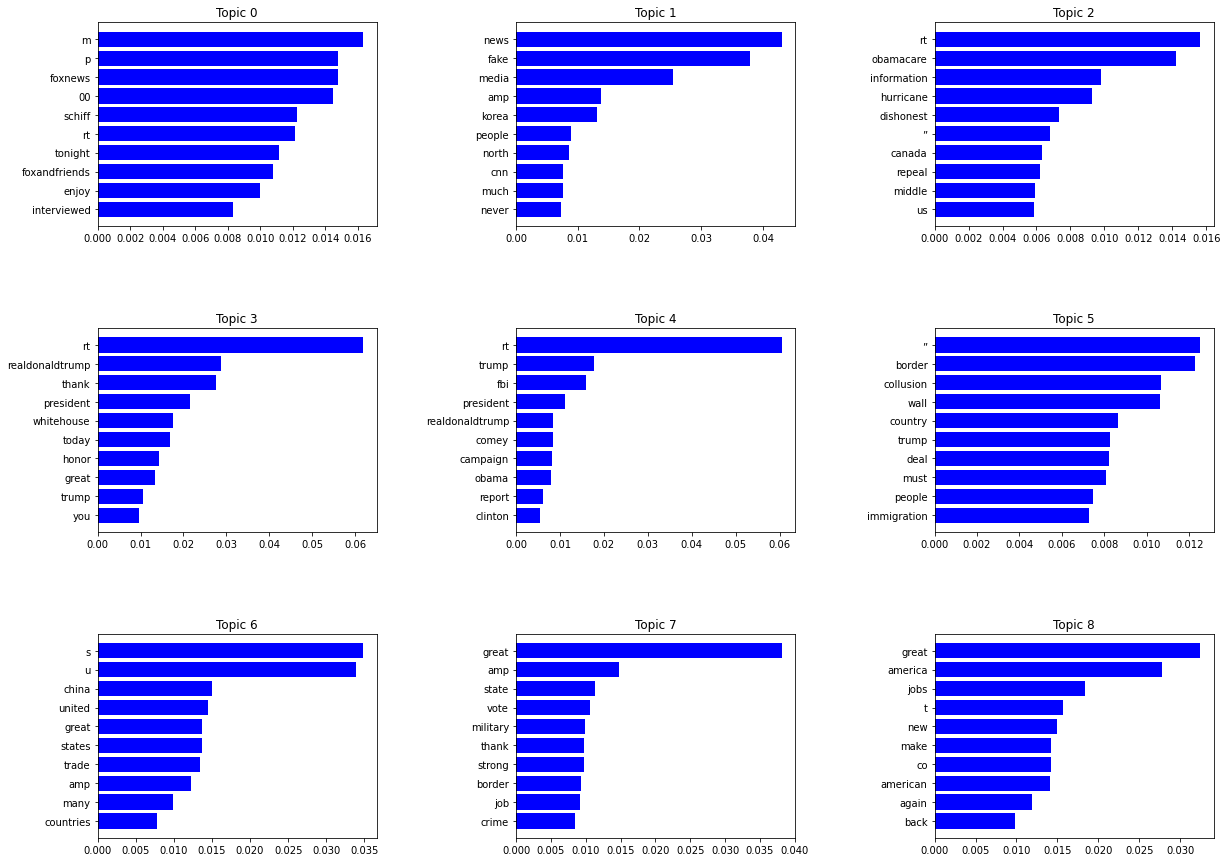

In [48]:
plot_top_words(new_lda, 9, 10)

In [65]:
true_line = ['The president is a fraud and should be impeached on the basis of his browser history alone', 
             'America has seen the greatest rise in its economy since Vladmir Putin became the de facto president']
true_seq = tokenizer.texts_to_sequences(true_line)
print(len(true_seq[0]), len(true_seq[1]))

17 17


In [59]:
pred = new_lda[build_lda_corpus(true_seq)]

In [60]:
pred = np.array(pred)
print(pred.shape)

(2,)


In [62]:
pred

array([list([(0, 0.14093894), (1, 0.06870345), (3, 0.09096206), (4, 0.13114375), (5, 0.17102918), (6, 0.093877055), (9, 0.2866765)]),
       list([(0, 0.106252104), (1, 0.14662474), (6, 0.4018121), (7, 0.07679867), (8, 0.24072558)])],
      dtype=object)

In [ ]:
true_seq

In [71]:
pred_ = new_lda.get_document_topics(build_lda_corpus(true_seq), minimum_probability = 0.0)
pred_ = np.array(pred_)
print(pred_.shape)

(2, 10, 2)


In [51]:
top_topics = new_lda.get_document_topics(build_lda_corpus(true_seq)[0], minimum_probability=0.0)
topic_vec = [top_topics[i][1] for i in range(10)]

In [52]:
print(top_topics)

[(0, 0.14094275), (1, 0.0687034), (2, 0.00555672), (3, 0.090952784), (4, 0.1312169), (5, 0.17096779), (6, 0.093871094), (7, 0.005556246), (8, 0.0055561364), (9, 0.28667614)]


In [53]:
topic_vec

[0.14094275,
 0.0687034,
 0.00555672,
 0.090952784,
 0.1312169,
 0.17096779,
 0.093871094,
 0.005556246,
 0.0055561364,
 0.28667614]

In [73]:
import tensorflow as tf

In [127]:
# Topic Prediction Layer for our model

class TopicPrediction(tf.keras.layers.Layer): 
  """
    Topic Prediction using a pre-trained gensim LdaModel
    init
      params : 
        LdaModel : instance of trained gensim.ldamodel.LdaModel
        num_topics : num_topics for the model
        dims : required dims for topic vector
    call() 
      params:
        inp : input batch of shape (batch_size, maxlen)
      returns :
          predicted topic tensor of shape (batch_size, dims)
  """
  def __init__(self, ldaModel, num_topics, dims):
    super(TopicPrediction, self).__init__(trainable= False)
    self.ldaModel = ldaModel
    assert(dims >= num_topics), f"The required dims({dims}) are less than num_topics ({num_topics})"
    self.dims = dims
    self.num_topics=num_topics

  def convert_to_corpus(self, sequences):
    corpus = []
    for num, line in enumerate(sequences):
      counts = [list(line).count(elt) for elt in line]
      line_ = list(set([(line.numpy()[i], counts[i]) for i in range(len(counts))]))
      corpus.append(line_)
    return corpus

  def call(self, inp):
    bs = inp.shape[0]
    vec = np.zeros((bs,self.dims))
    corpus = self.convert_to_corpus(inp)
    topic_vec = self.ldaModel.get_document_topics(corpus, minimum_probability = 0.0)
    topic_vec = np.array(topic_vec)[:, :, 1]
    vec[:, :self.num_topics] = topic_vec
    return tf.convert_to_tensor(vec)


In [128]:
test_topic_layer = TopicPrediction(new_lda, num_topics = 10, dims = 100)

In [129]:
a = test_topic_layer(tf.convert_to_tensor(true_seq))

In [132]:
print(a.shape)

(2, 100)
